<a href="https://colab.research.google.com/github/christinahsu12682/OS/blob/master/repetition_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Repetition codes

*Usage estimate: less than 1 minute on a Heron processor (NOTE: This is an estimate only. Your runtime might vary.)*

## Background

To enable real-time quantum error correction (QEC), you need to be able to dynamically control quantum program flow during execution so that quantum gates can be conditioned on measurement results. This tutorial runs the bit-flip code, which is a very simple form of QEC. It demonstrates a dynamic quantum circuit that can protect an encoded qubit from a single bit-flip error, and then evaluates the bit-flip code performance.

You can exploit additional ancilla qubits and entanglement to measure *stabilizers* that do not transform encoded quantum information, while still informing you of some classes of errors that might have occurred. A quantum stabilizer code encodes $k$ logical qubits into $n$ physical qubits. Stabilizer codes critically focus on correcting a discrete error set with support from the Pauli group $\Pi^n$.

For more information about QEC, refer to [Quantum Error Correction for Beginners.](https://arxiv.org/abs/0905.2794)



## Requirements

Before starting this tutorial, ensure that you have the following installed:

*   Qiskit SDK v2.0 or later with visualization support (`pip install qiskit[visualization]`)
*   Qiskit Runtime v0.40 or later (`pip install qiskit-ibm-runtime`)



## Setup



In [1]:
!pip install qiskit[visualisation] qiskit_ibm_runtime qiskit_aer pylatexenc -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.1 MB/s eta 0:00:00


In [2]:
# Qiskit imports
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
)

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeAlgiers
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

fake_algiers = FakeAlgiers()
pm = generate_preset_pass_manager(backend=fake_algiers, optimization_level=3)
backend=fake_algiers

## Step 1. Map classical inputs to a quantum problem



### Build a bit-flip stabilizer circuit

The bit-flip code is among the simplest examples of a stabilizer code. It protects the state against a single bit-flip (X) error on any of the encoding qubits. Consider the action of bit-flip error $X$, which maps $|0\rangle \rightarrow |1\rangle$ and $|1\rangle \rightarrow |0\rangle$ on any of our qubits, then we have $\epsilon = \{E_0, E_1, E_2 \} = \{IIX, IXI, XII\}$. The code requires five qubits: three are used to encode the protected state, and the remaining two are used as stabilizer measurement ancillas.



In [3]:
num_qubits = 5

In [4]:
qreg_data = QuantumRegister(3)
qreg_measure = QuantumRegister(2)
creg_data = ClassicalRegister(3, name="data")
creg_syndrome = ClassicalRegister(2, name="syndrome")
state_data = qreg_data[0]
ancillas_data = qreg_data[1:]


def build_qc():
    """Build a typical error correction circuit"""
    return QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome)


def initialize_qubits(circuit: QuantumCircuit):
    """Initialize qubit to |1>"""
    circuit.x(qreg_data[0])
    circuit.barrier(qreg_data)
    return circuit


def encode_bit_flip(circuit, state, ancillas) -> QuantumCircuit:
    """Encode bit-flip. This is done by simply adding a cx"""
    for ancilla in ancillas:
        circuit.cx(state, ancilla)
    circuit.barrier(state, *ancillas)
    return circuit


def measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_measure):
    """
    Measure the syndrome by measuring the parity.
    We reset our ancilla qubits after measuring the stabilizer
    so we can reuse them for repeated stabilizer measurements.
    Because we have already observed the state of the qubit,
    we can write the conditional reset protocol directly to
    avoid another round of qubit measurement if we used
    the `reset` instruction.
    """
    circuit.cx(qreg_data[0], qreg_measure[0])
    circuit.cx(qreg_data[1], qreg_measure[0])
    circuit.cx(qreg_data[0], qreg_measure[1])
    circuit.cx(qreg_data[2], qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    circuit.measure(qreg_measure, creg_measure)
    with circuit.if_test((creg_measure[0], 1)):
        circuit.x(qreg_measure[0])
    with circuit.if_test((creg_measure[1], 1)):
        circuit.x(qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    return circuit


def apply_correction_bit(circuit, qreg_data, creg_syndrome):
    """We can detect where an error occurred and correct our state"""
    with circuit.if_test((creg_syndrome, 3)):
        circuit.x(qreg_data[0])
    with circuit.if_test((creg_syndrome, 1)):
        circuit.x(qreg_data[1])
    with circuit.if_test((creg_syndrome, 2)):
        circuit.x(qreg_data[2])
    circuit.barrier(qreg_data)
    return circuit


def apply_final_readout(circuit, qreg_data, creg_data):
    """Read out the final measurements"""
    circuit.barrier(qreg_data)
    circuit.measure(qreg_data, creg_data)
    return circuit

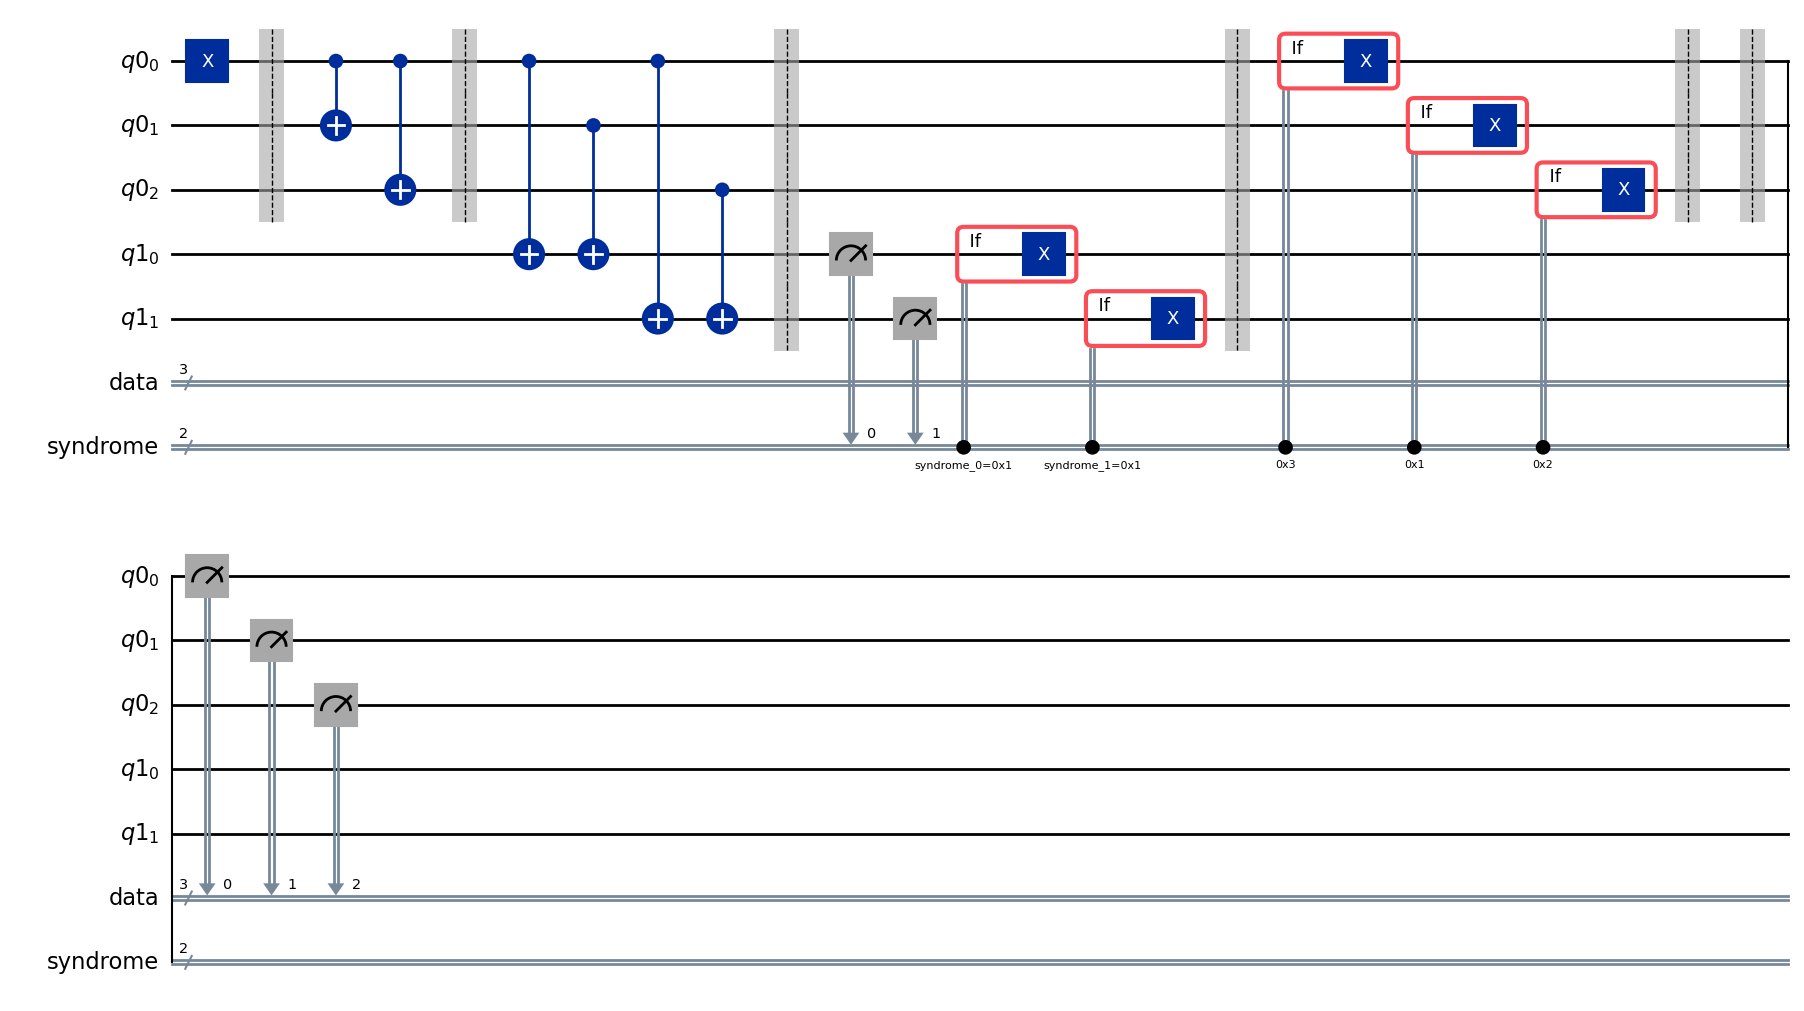

In [5]:
def build_error_correction_sequence(apply_correction: bool) -> QuantumCircuit:
    circuit = build_qc()
    circuit = initialize_qubits(circuit)
    circuit = encode_bit_flip(circuit, state_data, ancillas_data)
    circuit = measure_syndrome_bit(
        circuit, qreg_data, qreg_measure, creg_syndrome
    )

    if apply_correction:
        circuit = apply_correction_bit(circuit, qreg_data, creg_syndrome)

    circuit = apply_final_readout(circuit, qreg_data, creg_data)
    return circuit


circuit = build_error_correction_sequence(apply_correction=True)
circuit.draw(output="mpl", style="iqp")

## Step 2. Optimize the problem for quantum execution

To reduce the total job execution time, Qiskit primitives only accept circuits and observables that conforms to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).  [Learn more about transpilation.](/docs/guides/transpile)



### Generate ISA circuits



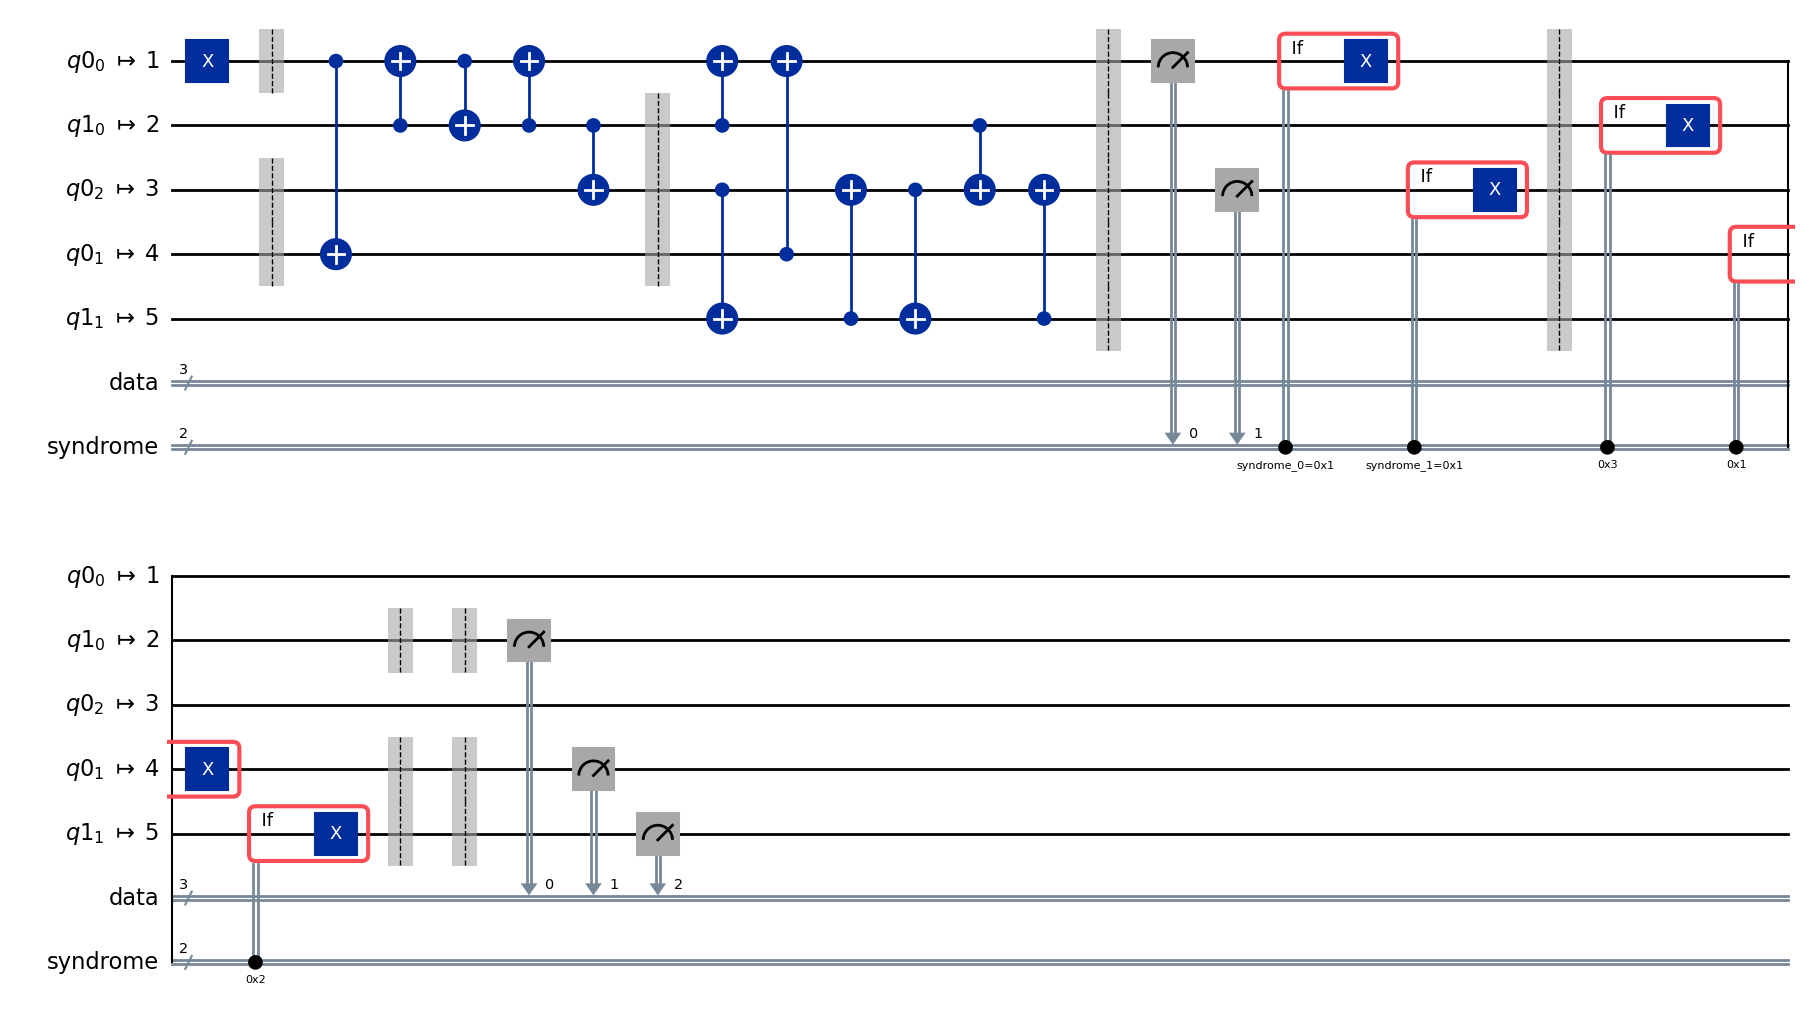

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw("mpl", style="iqp", idle_wires=False)

In [7]:
no_correction_circuit = build_error_correction_sequence(
    apply_correction=False
)

isa_no_correction_circuit = pm.run(no_correction_circuit)

## Step 3. Execute using Qiskit primitives



Run the version with correction applied and one without correction.



In [8]:
sampler_no_correction = Sampler(backend)
job_no_correction = sampler_no_correction.run(
    [isa_no_correction_circuit], shots=1000
)
result_no_correction = job_no_correction.result()[0]

In [9]:
sampler_with_correction = Sampler(backend)

job_with_correction = sampler_with_correction.run([isa_circuit], shots=1000)
result_with_correction = job_with_correction.result()[0]

In [10]:
print(f"Data (no correction):\n{result_no_correction.data.data.get_counts()}")
print(
    f"Syndrome (no correction):\n{result_no_correction.data.syndrome.get_counts()}"
)

Data (no correction):
{'111': 923, '110': 22, '101': 29, '011': 18, '010': 5, '000': 2, '100': 1}
Syndrome (no correction):
{'00': 944, '01': 32, '10': 21, '11': 3}


In [11]:
print(f"Data (corrected):\n{result_with_correction.data.data.get_counts()}")
print(
    f"Syndrome (corrected):\n{result_with_correction.data.syndrome.get_counts()}"
)

Data (corrected):
{'111': 909, '101': 15, '011': 40, '000': 12, '010': 14, '001': 2, '110': 7, '100': 1}
Syndrome (corrected):
{'00': 924, '10': 44, '01': 25, '11': 7}


## Step 4. Post-process, return result in classical format

You can see that the bit flip code detected and corrected many errors, resulting in fewer errors overall.



In [12]:
def decode_result(data_counts, syndrome_counts):
    shots = sum(data_counts.values())
    success_trials = data_counts.get("000", 0) + data_counts.get("111", 0)
    failed_trials = shots - success_trials
    error_correction_events = shots - syndrome_counts.get("00", 0)
    print(
        f"Bit flip errors were detected/corrected on {error_correction_events}/{shots} trials."
    )
    print(
        f"A final parity error was detected on {failed_trials}/{shots} trials."
    )

In [13]:
# non-corrected marginalized results
data_result = result_no_correction.data.data.get_counts()
marginalized_syndrome_result = result_no_correction.data.syndrome.get_counts()

print(
    f"Completed bit code experiment data measurement counts (no correction): {data_result}"
)
print(
    f"Completed bit code experiment syndrome measurement counts (no correction): {marginalized_syndrome_result}"
)
decode_result(data_result, marginalized_syndrome_result)

Completed bit code experiment data measurement counts (no correction): {'111': 923, '110': 22, '101': 29, '011': 18, '010': 5, '000': 2, '100': 1}
Completed bit code experiment syndrome measurement counts (no correction): {'00': 944, '01': 32, '10': 21, '11': 3}
Bit flip errors were detected/corrected on 56/1000 trials.
A final parity error was detected on 75/1000 trials.


In [14]:
# corrected marginalized results
corrected_data_result = result_with_correction.data.data.get_counts()
corrected_syndrome_result = result_with_correction.data.syndrome.get_counts()

print(
    f"Completed bit code experiment data measurement counts (corrected): {corrected_data_result}"
)
print(
    f"Completed bit code experiment syndrome measurement counts (corrected): {corrected_syndrome_result}"
)
decode_result(corrected_data_result, corrected_syndrome_result)

Completed bit code experiment data measurement counts (corrected): {'111': 909, '101': 15, '011': 40, '000': 12, '010': 14, '001': 2, '110': 7, '100': 1}
Completed bit code experiment syndrome measurement counts (corrected): {'00': 924, '10': 44, '01': 25, '11': 7}
Bit flip errors were detected/corrected on 76/1000 trials.
A final parity error was detected on 79/1000 trials.


## Shor's Code

{'0': 1024}

Shor code with bit flip and phase error
----------------------------------------
{'0': 1024}


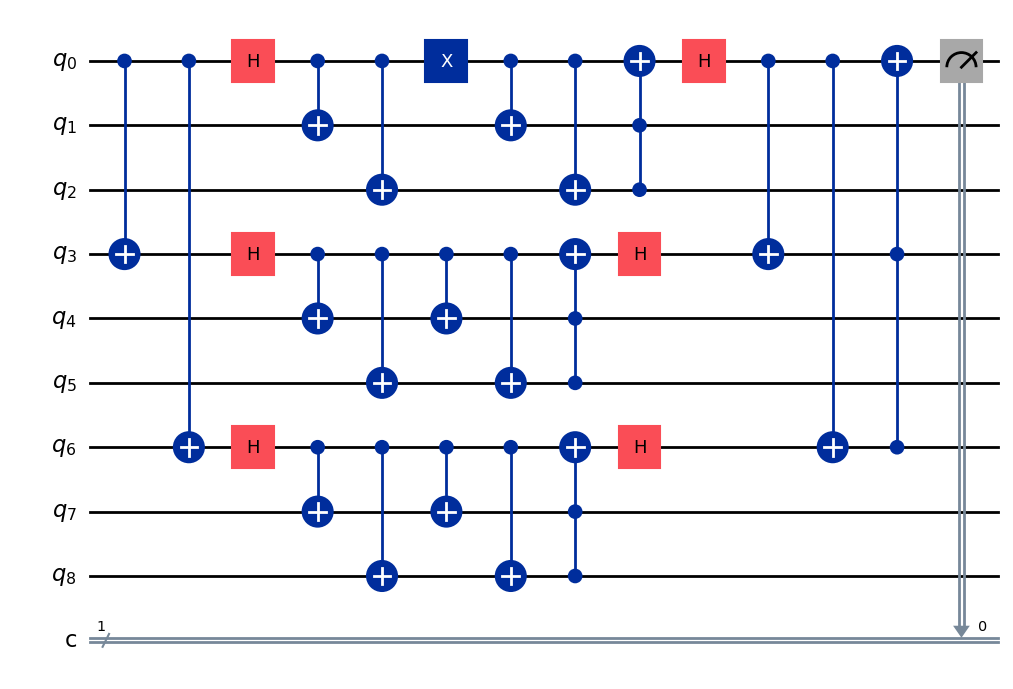

In [15]:
#Shor code starts here
q = QuantumRegister(9,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

#error here
circuit.x(q[0]) #Bit flip error
#circuit.z(q[0]) #Phase flip error

circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.ccx(q[1],q[2],q[0])
circuit.ccx(q[4],q[5],q[3])
circuit.ccx(q[8],q[7],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])
circuit.ccx(q[6],q[3],q[0])

circuit.measure(q[0],c[0])

simulator = AerSimulator()
#job = execute(circuit, backend, shots=1000)
#job_monitor(job)
#counts = job.result().get_counts()

result = simulator.run(circuit, shots=1024).result()
counts = result.get_counts()

print(counts)

print("\nShor code with bit flip and phase error")
print("----------------------------------------")
print(counts)
circuit.draw("mpl", style="iqp", idle_wires=False) #Draws an image of the circuit

## Tutorial survey

Please take this short survey to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_5onAlfA2Y7ac1FA)



© IBM Corp., 2017-2025